Используя любую предобученную сеть из библиотеки Pytorch, напишите нейронную 

сеть, сегментирующую изображение. Используйте базу движения по улицам Лондона.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt  # Этим блоком будем визуализировать
%matplotlib inline
from PIL import Image


# Библиотеки Pytorch
import torch 

import torchvision.transforms as T  # библиотека для преобразования изображений

import datetime, os


Развернем тестовые изображения

In [ ]:
!unzip -q /content/drive/MyDrive/images_prepped_test-20211117T162423Z-001.zip
!unzip -q /content/drive/MyDrive/annotations_prepped_test-20211117T162402Z-001.zip

Картинки на диске

In [ ]:
imgPath = '/content/images_prepped_test/' 
listImg = sorted(os.listdir(imgPath))
print(len(listImg ))

101


In [ ]:
annPath = '/content/annotations_prepped_test/' 
listAnn = sorted(os.listdir(annPath))
print(len(listAnn))

101


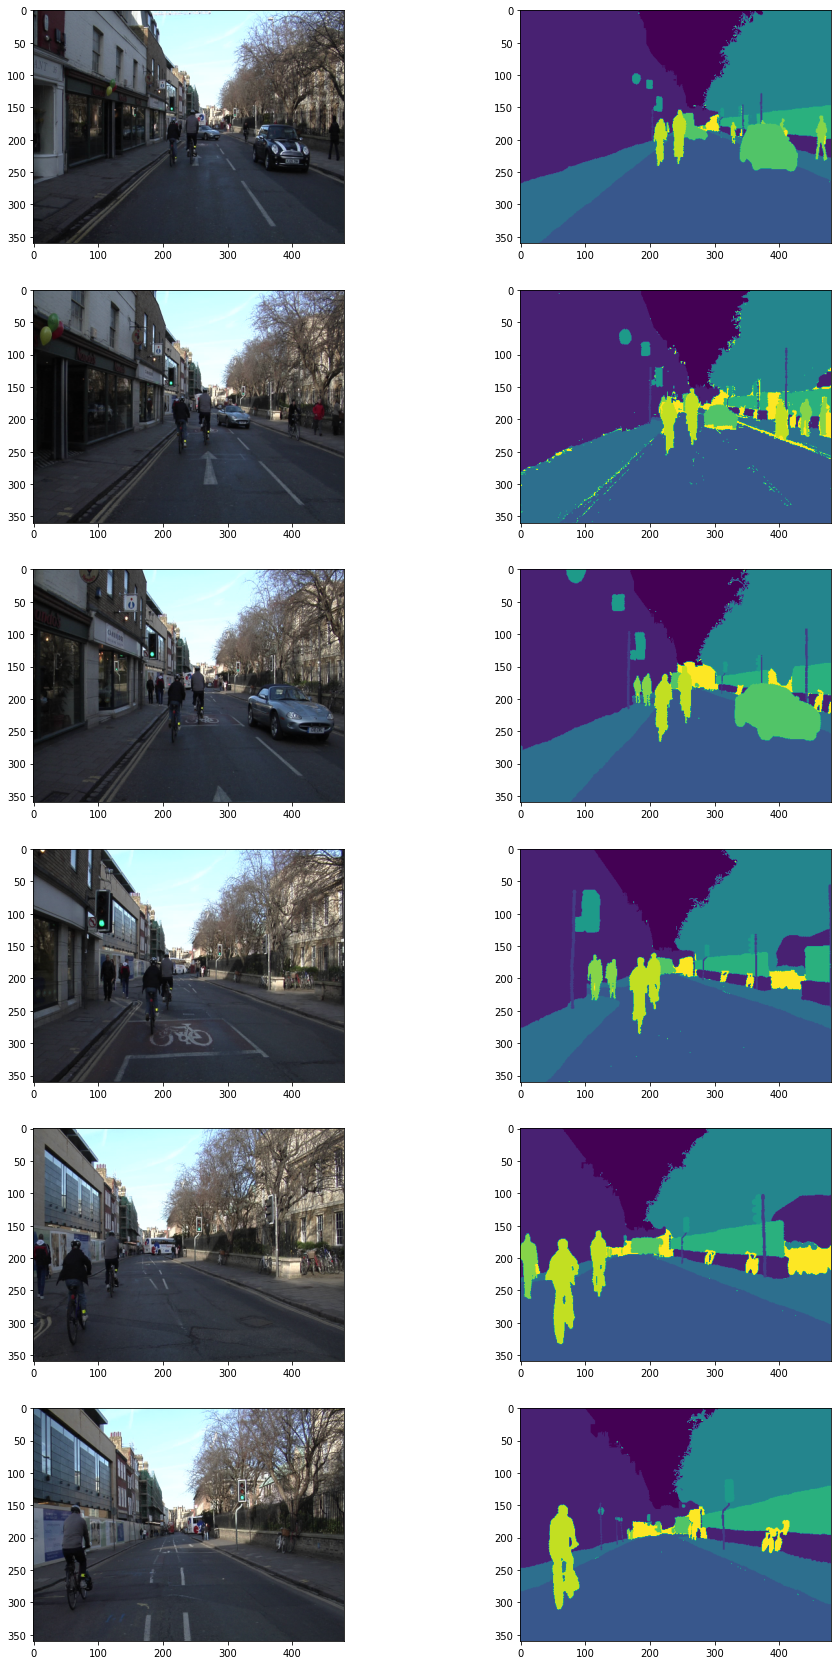

In [ ]:
n = 6 # Количество выводимых пар картинок
fig, axs = plt.subplots(n, 2, figsize=(16, 30)) # Создаем полотно из n*2n графиков
for i, img in enumerate(listImg):
  if not (i %20) : 
    axs[i//20,0].imshow(Image.open(imgPath + img))
    axs[i//20,1].imshow(Image.open(annPath + img))
plt.show() # Показываем изображения 

Проверим на 1-й картинке

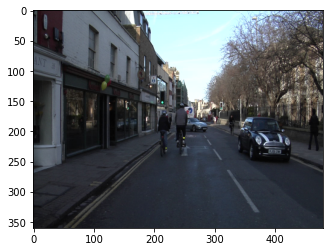

In [ ]:
img = Image.open(imgPath + listImg[0])
plt.imshow(img)

In [ ]:
# Подготовка для подачи в сеть
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

Загрузим модели

In [ ]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


  0%|          | 0.00/208M [00:00<?, ?B/s]

In [ ]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Выход модели

In [ ]:
# Pass the input through the net
out = dlab(inp)['out']
print (out.shape)

torch.Size([1, 21, 224, 224])


In [ ]:

om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(224, 224)
[ 0  7 15]


Функция преобразования сегмента в цвет

In [ ]:

def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g, b = r.copy(), r.copy()
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

Результат работы модели

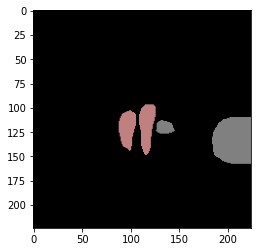

In [ ]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

Сегментируем выбранные изображения 2-мя моделями

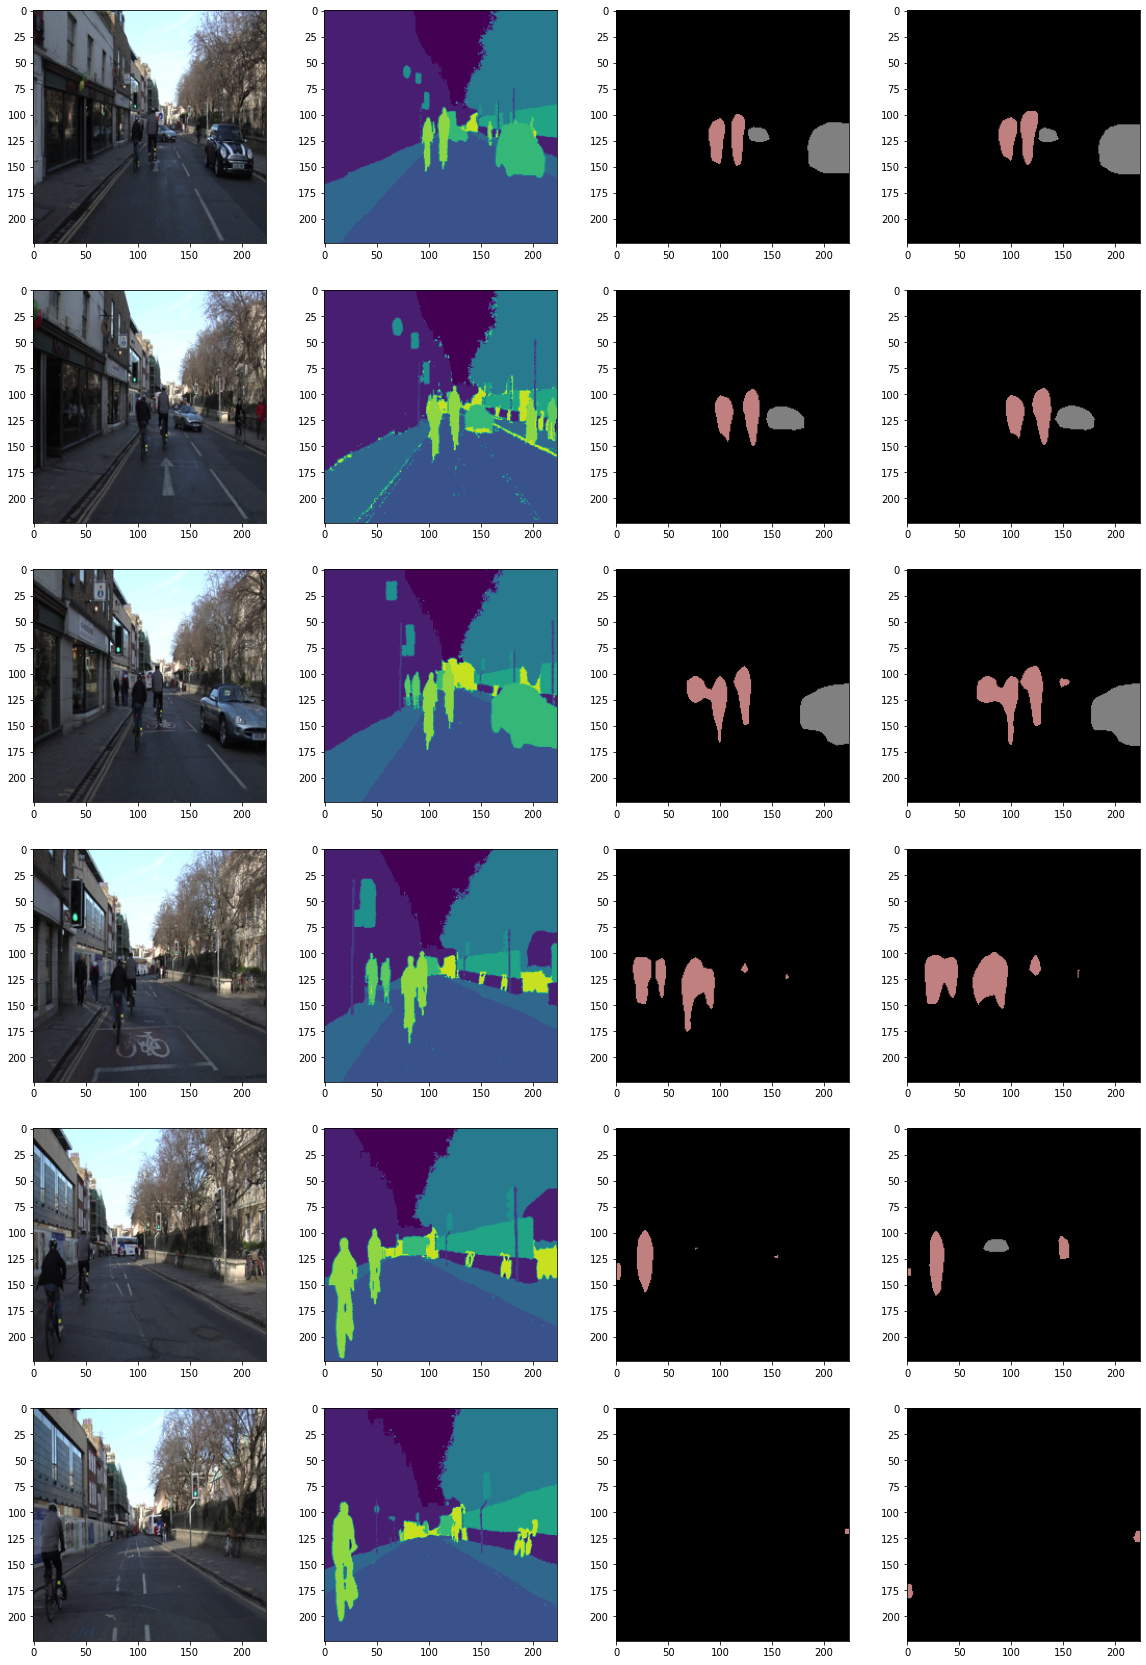

In [ ]:
n = 6 # Количество выводимых пар картинок
fig, axs = plt.subplots(n, 4, figsize=(20, 30)) # Создаем полотно из n*2n графиков
for i, im in enumerate(listImg):
  if not (i %20) :
    img = Image.open(imgPath + im)
    imgs = img.resize((256,256))
    imgs = imgs.crop((16, 16, 240, 240))    # Обрезаем картинку как в трансформации PyTorch
    axs[i//20,0].imshow(imgs)
    seg = Image.open(annPath + im)
    seg= seg.resize((256,256))
    seg= seg.crop((16, 16, 240, 240))
    axs[i//20,1].imshow(seg)

    inp = trf(img).unsqueeze(0)             # Подготовка входа
    out = fcn(inp)['out']                   # Сегментация
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    axs[i//20,2].imshow(rgb)

    out = dlab(inp)['out']                  # Сегментация
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    axs[i//20,3].imshow(rgb)
plt.show() # Показываем изображения 